##Анализ данных о сердечно-сосудистых заболеваниях (поиск инсайтов, составление рекомендаций стейкхолдерам, построение предиктивной модели классификации наличия заболевания).


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pylab import rcParams
rcParams['figure.figsize'] = 11,7

In [ ]:
df = pd.read_csv('cardio_train.csv', sep = ';')

### Признаки:
#### Объективные признаки

*   Возраст | age | int (days)
*   Рост | height | int (cm) 
*   Вес | weight | float (kg)
*   Пол | gender | categorical code | 1 - женский, 2 - мужской

#### Диагностические признаки

*   Систолическое кровяное давление | ap_hi | int 
*   Диастолическое кровяное давление | ap_lo | int
*   Уровень холестерина в крови | cholesterol | 1 - нормальный, 2 - повышенный, 3 - значительно выше нормы
*   Уровень сахара в крови | gluc | 1 - нормальный, 2 - повышенный, 3 - значительно выше нормы

#### Поведенческие признаки

*   Курение | smoke | binary | 1 - да, 0 - нет
*   Употребление алкоголя | alco | binary | 1 - да, 0 - нет
*   Физическая активность | active | binary | 1 - да, 0 - нет

#### Целевой признак

*   Наличие или отсутствие ССЗ | cardio | binary | 1 - да, 0 - нет


In [ ]:
df.head(5)

In [ ]:
df.info()

In [ ]:
df.groupby(df.gender)[['height', 'weight']].agg('mean')
# Будем считать 1 - женщина, 2 - мужчина

In [ ]:
# Введем столбец Возраст в годах age_years. Как правило, в медицинских документах фигурирует полный возраст в годах
df['age_years'] = df['age']//365.25
df.head(5)

### Проверка на полноту и корректность данных

Корректируем данные признаков height, weight, ap_hi, ap_lo.
Возьмем за основу методику определения границ выбросов через межквартильный размах.

Т.к. статистики признаков различны у мужчин и женщин, смотрим корректность данных отдельно.

In [ ]:
# Функция выводит боксплот по признаку feature, параметр - Пол. 
def graf_outliers(feature):
  rcParams['figure.figsize'] =(10 , 8)
  boxplot = sns.boxplot(x = 'gender', y=feature, data=df)
  boxplot.axes.set_title('Распределение значений признака ' + feature, fontsize=16)
  boxplot.set_xlabel('Пол (1 - женский, 2 - мужской)', fontsize=14)
  boxplot.set_ylabel('Значения', fontsize=14);

In [ ]:
# Функция рассчитывает нижнюю и верхнюю границу выбросов признака feature, параметр - пол.
# Выводит список пар значений границ выбросов.
def outliers_boundary(feature):
  bounderis = []
  for i in range(1,3):
    q1 = df.loc[df.gender == i][feature].quantile(0.25)
    q3 = df.loc[df.gender == i][feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    bounderis.append([lower_bound, upper_bound])

  print('Нижняя граница. Женщины - ', bounderis[0][0], 'Мужчины - ', bounderis[1][0]) 
  print('Верхняя граница Женщины - ', bounderis[0][1], 'Мужчины - ', bounderis[1][1])
  return bounderis

#### Рост (height)



Нижняя граница. Женщины -  143.5 Мужчины -  150.0
Верхняя граница Женщины -  179.5 Мужчины -  190.0


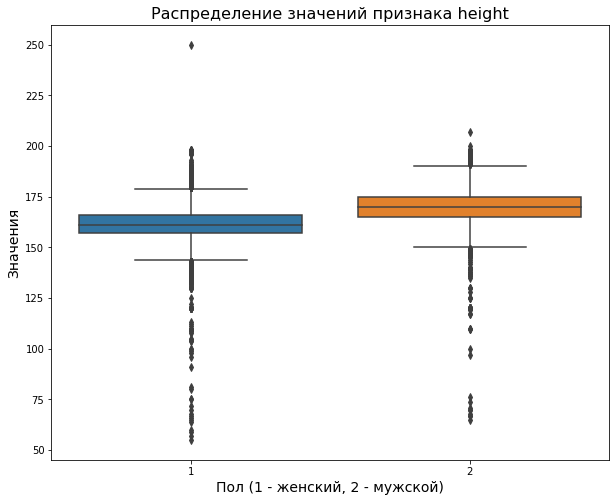

In [ ]:
graf_outliers('height')
bounderis_height = outliers_boundary('height')

In [ ]:
# Женщины: мах значение 250 удаляем, далее 198, что считаем допустимым. 
# Мужчины: мах значение 207 считаем допустимым.
# Нижнюю границу выбросов установим исходя из принятых в медицине границ карликового роста: 120 см для женщин, 130 см для мужчин.
filer_height_women = (df.gender == 1) & ((df.height == 250) | (df.height < 120))
filer_height_men = (df.gender == 2) & (df.height < 130)
outliers_height = df.loc[(filer_height_women) | (filer_height_men)].index
len(outliers_height)   

72

#### ВЕС (weight)


Нижняя граница. Женщины -  37.5 Мужчины -  42.5
Верхняя граница Женщины -  105.5 Мужчины -  110.5


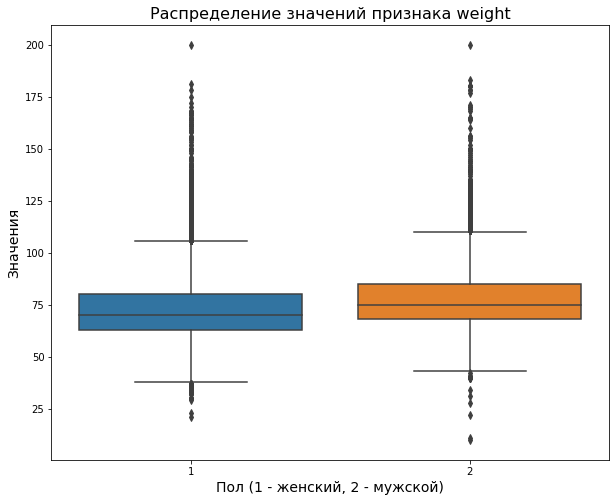

In [ ]:
graf_outliers('weight')
bounderis_weight = outliers_boundary('weight')

In [ ]:
# Количество людей, страдающих ожирением, в мире только растет. Поэтому вес свыше 100 кг нельзя считать аномальным. 
# В контексте данного направления исследования излишний вес может быть одним из факторов, влияющих на возникновение ССЗ. 
# Поэтому удаляем только максимальные значения 200 (по одному и мужчин и женщин) и данные, в которых вес меньше 37.5 кг у женщин и 42.5 кг у мужчин.
filer_weight_women = (df.gender == 1) & ((df.weight == 200) | (df.weight < bounderis_weight[0][0]))
filer_weight_men = (df.gender == 2) & ((df.weight == 200) | (df.weight < bounderis_weight[1][0]))
outliers_weight = df.loc[(filer_weight_women) | (filer_weight_men)].index
len(outliers_weight)   

45

#### Давление (ap_hi, ap_lo)

Нижняя граница. Женщины -  90.0 Мужчины -  90.0
Верхняя граница Женщины -  170.0 Мужчины -  170.0


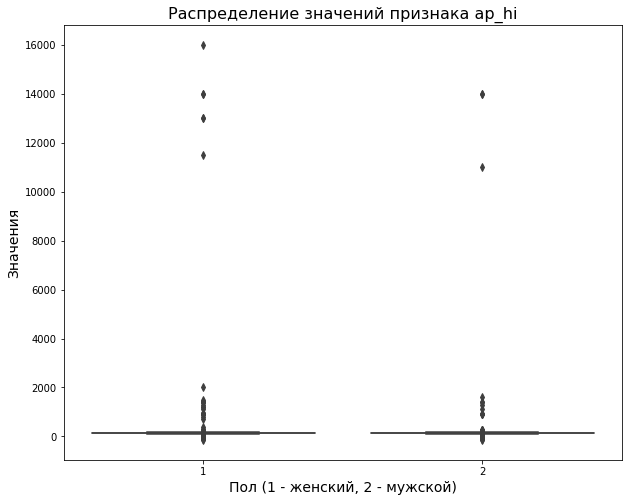

In [ ]:
graf_outliers('ap_hi')
bounderis_ap_hi = outliers_boundary('ap_hi')

Нижняя граница. Женщины -  65.0 Мужчины -  65.0
Верхняя граница Женщины -  105.0 Мужчины -  105.0


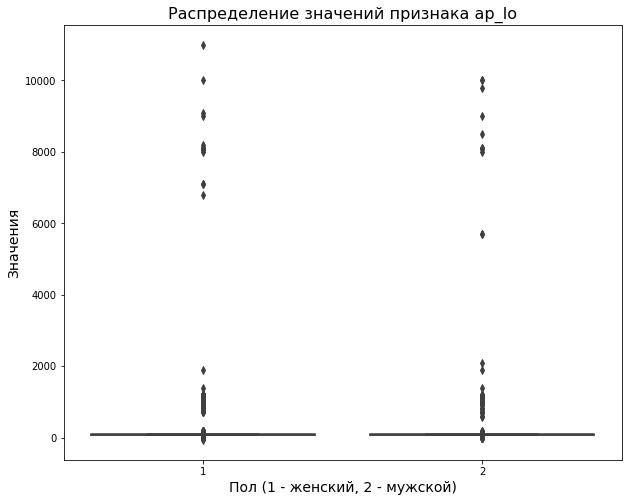

In [ ]:
graf_outliers('ap_lo')
bounderis_ap_lo = outliers_boundary('ap_lo')

In [ ]:
# Значения одинаковы для мужского и женского пола и явно не соответствуют данным медицинской практики.
# Поэтому будем руководствоваться следующими данными.
# В медицинской практике критическим считается давление ниже 80 для систолического и ниже 50 для диастолического.
# Максимально зафиксированное высокое давление 310/220. В качестве верхней границы допустимости данным возьмем этот показатель, уменьшенный на 20%, 
# т.е. 250 для систолического и 180 для диастолического давления. 
# Кроме того, удалим записи, в которых ap_hi < ap_lo
filer_ap_hi = (df.ap_hi > 250) | (df.ap_hi < 80)
filer_ap_lo = (df.ap_lo > 180) | (df.ap_lo < 50)
filer_ap_add = df.ap_hi < df.ap_lo
outliers_ap = df.loc[(filer_ap_hi) | (filer_ap_lo) | (filer_ap_add)].index
len(outliers_ap)   

1349

In [ ]:
outliers = outliers_height | outliers_weight | outliers_ap
len(outliers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  """Entry point for launching an IPython kernel.


1459

In [ ]:
df_work = df.drop(outliers)

In [ ]:
# Удалим 4 строки возраст 29-30 лет  
df_work = df_work.loc[df_work['age_years'] > 30] 

In [ ]:
# Введем признак Индекс массы тела
df_work['BMI'] = df_work['weight']/np.power(df_work['height'] / 100, 2)

In [ ]:
df_work.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
count,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000,68537.000000
mean,49973.371974,19465.348717,1.348571,164.432963,74.133733,126.683324,81.323767,1.364869,1.225776,0.087982,0.053373,0.803333,0.494813,52.793644
std,28847.877973,2467.022348,0.476521,7.873384,14.257967,16.680568,9.419566,0.679052,0.571649,0.283270,0.224777,0.397482,0.499977,6.761800
min,0.000000,14275.000000,1.000000,120.000000,38.000000,80.000000,50.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,39.000000
25%,25002.000000,17658.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,50010.000000,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000
75%,74873.000000,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,99999.000000,23713.000000,2.000000,207.000000,183.000000,240.000000,180.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000


Удалили 1463 записи.



### Анализ данных


In [ ]:
# Распределение по половому признаку: женщины - 65%, мужчины - 35% 
df_work['gender'].value_counts()

1    44647
2    23890
Name: gender, dtype: int64

In [ ]:
# Диагностировано ССЗ - 49%, нет - 51%
df_work['cardio'].value_counts() 

0    34624
1    33913
Name: cardio, dtype: int64

In [ ]:
# Доля заболевших среди женщин - 49%, среди мужчин - 50%
df_work[['gender', 'cardio']].value_counts()

gender  cardio
1       0         22672
        1         21975
2       0         11952
        1         11938
dtype: int64

In [ ]:
# Сформируем таблицу: заболеваемость ССЗ среди пациентов, имеющих нормальные/положительные значения признаков 
# condition - Условие отбора определенного признака
# part_of_all - доля отобранных пациентов от общего количества, %
# cardio_part_of_all - доля диагностирования ССЗ у отобранных пациентов 
df_work_info = pd.DataFrame(columns=['condition', 'part_of_all', 'cardio_part_of_all'])


In [ ]:
# Функция рассчитывает коэффициенты part_of_all и cardio_part_of_all и добавляет данные в df_work_info
def normal_feature_values(feature_condition, filter):
  global df_work_info
  norm_feature_percent = round(df_work.loc[filter]['id'].count() / df_work['id'].count() * 100, 1)
  norm_feature_cardio_percent = round(df_work.loc[filter & df_work.cardio == 1]['id'].count() / df_work.loc[filter]['id'].count() *100,1)
  df_work_info = df_work_info.append({'condition' : feature_condition, 
                                      'part_of_all' : norm_feature_percent, 
                                      'cardio_part_of_all' : norm_feature_cardio_percent}, 
                                     ignore_index=True)
  

In [ ]:
normal_feature_values('ИМТ в норме', (df_work.BMI > 18) & (df_work.BMI < 25))
normal_feature_values('Давление ap_hi в норме', (df_work.ap_hi >120) & (df_work.ap_hi < 145))
normal_feature_values('Холестерин в норме', df_work.cholesterol == 1)
normal_feature_values('Сахар в норме', df_work.gluc == 1)
normal_feature_values('Не курят', df_work.smoke == 0)
normal_feature_values('Не употребляют алкоголь', df_work.alco == 0)
normal_feature_values('Физически активны', df_work.active == 1)
normal_feature_values('Не курят, не пьют, физически активны', (df_work.smoke == 0) & (df_work.alco == 0) & (df_work.active == 1))
normal_feature_values('Курят, пьют, физически не активны', ~((df_work.smoke == 0) & (df_work.alco == 0) & (df_work.active == 1)))

filter_health = ((df_work.BMI > 18) & (df_work.BMI < 25)) & ((df_work.ap_hi >120) & (df_work.ap_hi < 145)) & (df_work.cholesterol == 1) & (df_work.gluc == 1)
normal_feature_values('Диагностика и ИМТ в норме', filter_health)
normal_feature_values('Диагностика и ИМТ не в норме', ~filter_health)

In [ ]:
df_work_info

,condition,part_of_all,cardio_part_of_all
0,ИМТ в норме,37.4,39.7
1,Давление ap_hi в норме,27.9,69.8
2,Холестерин в норме,75.0,43.6
3,Сахар в норме,85.0,47.6
4,Не курят,91.2,49.7
5,Не употребляют алкоголь,94.7,49.6
6,Физически активны,80.3,48.5
7,"Не курят, не пьют, физически активны",70.7,48.8
8,"Курят, пьют, физически не активны",29.3,51.1
9,Диагностика и ИМТ в норме,4.9,63.2


####Выводы:
Практически одинаковая заболеваемость у пациентов с положительными и отрицательными поведенческими признаками. Поэтому их влияние на риск ССЗ возможно незначительное.

Доля нормальных показателей каждого в отдельности велика, в сумме 4.9%, т.е. большинство пациентов имеют хотя бы один признак со значением не в норме.

Среди пациентов с нормальными показателями по всем признакам заболеваемость выше средней по датасету. Полагаю, причина во влиянии факторов, не зафиксированных в имеющихся данных.

### Исследуем зависимости.

Исследуем возможные зависимости между признаками. 

* Связь поведенческих факторов с возникновением ССЗ.
* Связь поведенческих факторов с диагностическими  показателями.
* Связь диагностических показателей с возникновением ССЗ


##### Рассмотрим взаимосвязь признаков на основе матрицы корреляции .



Корреляция целевого признака cardio с другими признаками: 
  
   * Диагностические признаки. Положительная корреляция
    - давление: ap_hi - 0.43, ap_lo - 0.34
    - уровень холестерина: cholesterol - 0.22
    - уровень сахара: gluc - 0.09  

   * Объективные признаки. Положительная корреляция с признаками возраст  и вес. Невысокие коэффициенты корреляции c признаками пол и рост. 
    - возраст: age_years - 0.24
    - ИМТ: BMI - 0.19
  
  
  * Поведенческие признаки. Невысокие коэффициенты корреляции c признаками курение, алкоголь, физическая активность. Отрицательная корреляция с признаками курение и алкоголь свидетельствует об отсутствии повышенного риска возникновения ССЗ у крящих и принимающих алкоголь людей (нет прямой зависимости). У физически активных людей ниже риск возникновения ССЗ. 
    - курение: smoke - -0.02
    - алкоголь: alco - -0.01
    - активность: active - -0.04

Взаимосвязь поведенческих и диагностических признаков. Диагностические признаки имеют положительную связь, невысокие коэффициенты корреляции (0.01 - 0.04) с признаками smoke и alco 

Из объективных признаков рассмотрим отдельно взаимосвязь веса с поведенческими и диагностическими признаками. Вес во многом зависит от образа жизни, питания, а излишний вес (ожирение) является одной из причин возникновения различных заболеваний, в т.ч. сердечно-сосудистых и приводит к изменению различных диагностических признаков. 

  * Диагностические признаки. Положительная корреляция
    - давление: ap_hi - 0.25, ap_lo - 0.27
    - уровень холестерина: cholesterol - 0.17
    - уровень сахара: gluc - 0.12  

  * Поведенческие признаки. 
    - курение: smoke - -0.03
    - алкоголь: alco - 0.02
    - активность: active - -0.01

В части физической активности можно однозначно сказать, что большая активность способствует снижению веса. Отрицательный коэффициент корреляции с признаком smoke подтверждает факт увеличения веса у бросивших курить. В части алкоголя сложно определить причинную связь: алкоголь способствуют увеличению веса или просто среди полных людей больше употребляющих алкоголь. 

In [ ]:
df_work.corr(method = 'pearson').style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  """Entry point for launching an IPython kernel.


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
id,1.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
age,0.00,1.00,-0.02,-0.09,0.06,0.21,0.16,0.16,0.10,-0.05,-0.03,-0.01,0.24,1.00,0.10
gender,0.00,-0.02,1.00,0.52,0.16,0.06,0.07,-0.04,-0.02,0.34,0.17,0.01,0.01,-0.02,-0.11
height,-0.00,-0.09,0.52,1.00,0.31,0.02,0.03,-0.06,-0.02,0.20,0.10,-0.01,-0.01,-0.09,-0.21
weight,-0.00,0.06,0.16,0.31,1.00,0.27,0.25,0.14,0.11,0.07,0.07,-0.02,0.18,0.06,0.86
ap_hi,0.00,0.21,0.06,0.02,0.27,1.00,0.74,0.20,0.09,0.03,0.04,-0.00,0.43,0.21,0.27
ap_lo,-0.00,0.16,0.07,0.03,0.25,0.74,1.00,0.16,0.08,0.03,0.04,-0.00,0.34,0.16,0.24
cholesterol,0.01,0.16,-0.04,-0.06,0.14,0.20,0.16,1.00,0.45,0.01,0.04,0.01,0.22,0.15,0.17
gluc,0.00,0.10,-0.02,-0.02,0.11,0.09,0.08,0.45,1.00,-0.01,0.01,-0.01,0.09,0.10,0.12
smoke,-0.00,-0.05,0.34,0.20,0.07,0.03,0.03,0.01,-0.01,1.00,0.34,0.03,-0.02,-0.05,-0.03


##### Оценим статистическую значимость коэффициентов корреляции. Для расчета  воспользуемся следующими методами:

* Матрица корреляции Пирсона - для числовых признаков

* Хи-квадрат статистика, тест Фишера - для категориальных признаков

* Бисериальная корреляция - для числовых и категориальных признаков.


In [ ]:
import scipy.stats as stats
from scipy.stats import pearsonr, chi2_contingency, fisher_exact, pointbiserialr

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(14, 14))

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

In [ ]:
# Бисериальная корреляция
# Функция определяет коэффициент корреляции и значение p-value числового и категориального признаков
def pb(f_cat, f_num):
  r = pointbiserialr(df_work[f_cat], df_work[f_num])
  print(f'Корреляция {f_cat} - {f_num} : {r[0]:.4f}. P-value: {r[1]:.4f}')

In [ ]:
# Метод Пирсона
# Функция определяет коэффициент корреляции и значение p-value двух числовых признаков
def pearson_korr(f1_num, f2_num):
  r = pearsonr(df_work[f1_num], df_work[f2_num])
  print(f'Корреляция {f1_num} - {f2_num} : {r[0]:.4f}. P-value: {r[1]:.4f}')

In [ ]:
# Метод Фишера
# Функция определяет коэффициент корреляции и значение p-value двух категориальных признаков
def fe(f1_cat, f2_cat):
  r = pearsonr(df_work[f1_cat], df_work[f2_cat])
  print(f'Корреляция {f1_cat} - {f2_cat} : {r[0]:.4f}. P-value: {r[1]:.4f}')

##### Диагностические показатели - ССЗ

In [ ]:
# Диагностические показатели - ССЗ
pb('ap_hi','cardio')
pb('cholesterol','cardio')
pb('gluc','cardio')
# Корреляция присутствует, стстистически значима

Корреляция ap_hi - cardio : 0.4279. P-value: 0.0000
Корреляция cholesterol - cardio : 0.2214. P-value: 0.0000
Корреляция gluc - cardio : 0.0895. P-value: 0.0000


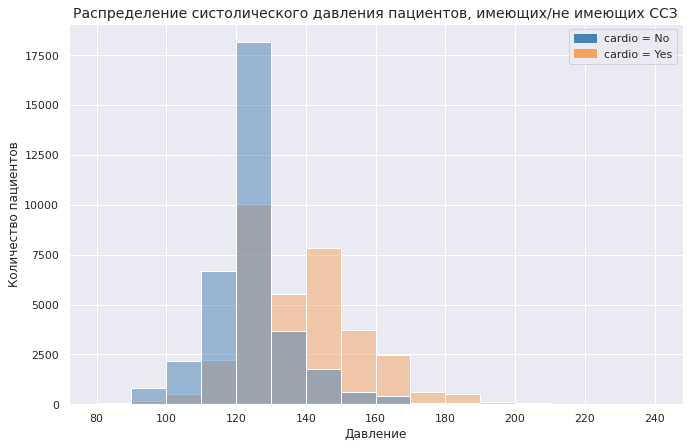

In [ ]:
sns.histplot(
    data= df_work, 
    x = 'ap_hi', 
    binwidth=10, 
    hue = 'cardio', 
    stat='count', 
    palette = ['steelblue', 'sandybrown']
)
rcParams['axes.titlesize'] = 14
plt.title('Распределение систолического давления пациентов, имеющих/не имеющих ССЗ')
plt.xlabel('Давление')
plt.ylabel('Количество пациентов')

top_bar = mpatches.Patch(color='steelblue', label='cardio = No')
bottom_bar = mpatches.Patch(color='sandybrown', label='cardio = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='upper right')

plt.show()

# Повышенное систолическое давление (> 130) приводит к возникновению ССЗ. Этот признак необходимо контролировать с целью выявления риска возникновения ССЗ

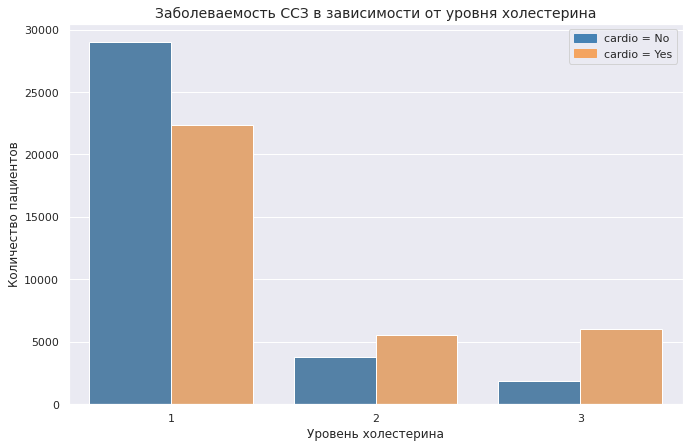

In [ ]:
df_work_gr1 = df_work.groupby(['cholesterol', 'cardio'])['id'].count().reset_index()
sns.barplot(
    x='cholesterol', 
    y='id',
    data=df_work_gr1,
    hue='cardio',
    palette = ['steelblue', 'sandybrown']
)

plt.title('Заболеваемость ССЗ в зависимости от уровня холестерина')
plt.xlabel('Уровень холестерина')
plt.ylabel('Количество пациентов')


top_bar = mpatches.Patch(color='steelblue', label='cardio = No')
bottom_bar = mpatches.Patch(color='sandybrown', label='cardio = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='upper right')

plt.show()

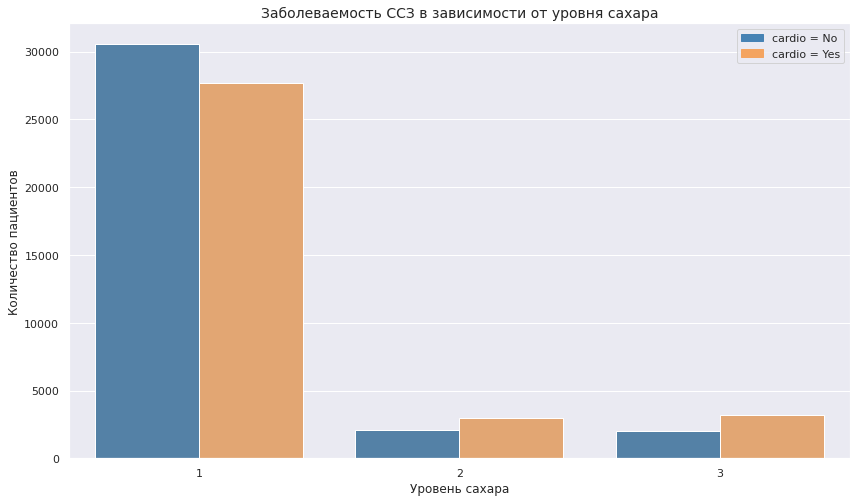

In [ ]:
df_work_gr1 = df_work.groupby(['gluc', 'cardio'])['id'].count().reset_index()
sns.barplot(
    x='gluc', 
    y='id',
    data=df_work_gr1,
    hue='cardio',
    palette = ['steelblue', 'sandybrown']
)

plt.title('Заболеваемость ССЗ в зависимости от уровня сахара')
plt.xlabel('Уровень сахара')
plt.ylabel('Количество пациентов')


top_bar = mpatches.Patch(color='steelblue', label='cardio = No')
bottom_bar = mpatches.Patch(color='sandybrown', label='cardio = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='upper right')

plt.show()

##### Объективные показатели (ИМТ, возраст, пол) - ССЗ


In [ ]:
pb('BMI','cardio')
# Корреляция присутствует, статистически значима

Корреляция BMI - cardio : 0.1900. P-value: 0.0000


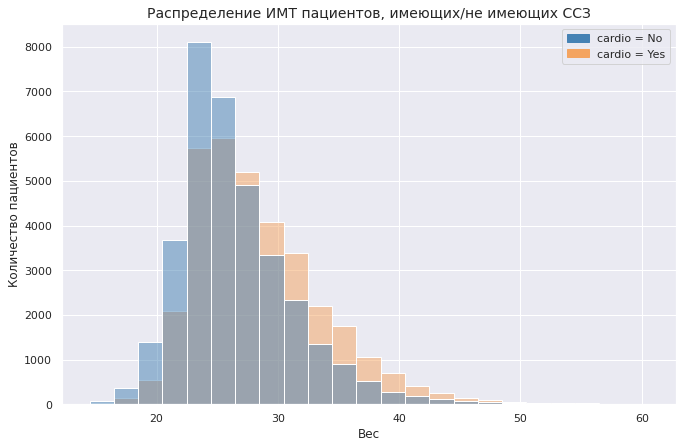

In [ ]:
sns.histplot(
    data= df_work.loc[df_work.BMI<60], 
    x = 'BMI', 
    binwidth=2, 
    hue = 'cardio', 
    stat='count', 
    palette = ['steelblue', 'sandybrown']
)
rcParams['axes.titlesize'] = 14
plt.title('Распределение ИМТ пациентов, имеющих/не имеющих ССЗ')
plt.xlabel('Вес')
plt.ylabel('Количество пациентов')

top_bar = mpatches.Patch(color='steelblue', label='cardio = No')
bottom_bar = mpatches.Patch(color='sandybrown', label='cardio = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='upper right')

plt.show()

In [ ]:
pb('age_years','cardio')
# Корреляция присутствует, статистически значима

Корреляция age_years - cardio : 0.2391. P-value: 0.0000


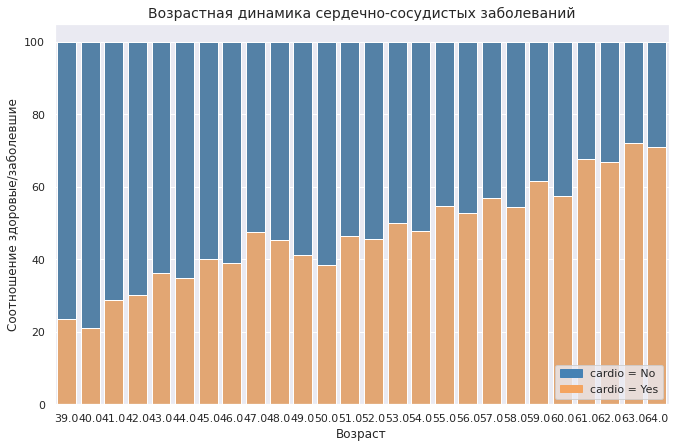

In [ ]:
# Нормированный график Доля заболевших в зависимости от возраста.
df_work_group = df_work.groupby('age_years')['cardio'].count().reset_index()
df_work_group_bot = df_work.loc[df_work['cardio'] == 1].groupby('age_years')['cardio'].count().reset_index()

df_work_group_bot['cardio'] = [i / j * 100 for i,j in zip(df_work_group_bot['cardio'], df_work_group['cardio'])]
df_work_group['cardio'] = [i / j * 100 for i,j in zip(df_work_group['cardio'], df_work_group['cardio'])]

bar1 = sns.barplot(x='age_years',  y='cardio', data=df_work_group, color='steelblue')
bar2 = sns.barplot(x='age_years', y='cardio', data=df_work_group_bot,  color='sandybrown')

bar1.set_title('Возрастная динамика сердечно-сосудистых заболеваний', fontsize=14)
bar1.set_xlabel("Возраст", fontsize=12)
bar1.set_ylabel("Соотношение здоровые/заболевшие", fontsize=12)


top_bar = mpatches.Patch(color='steelblue', label='cardio = No')
bottom_bar = mpatches.Patch(color='sandybrown', label='cardio = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='lower right')
plt.show()

In [ ]:
fe('gender','cardio')
# Зависимость возникновения ССЗ от пола статистически не подтверждена

Корреляция gender - cardio : 0.0072. P-value: 0.0609


##### Поведенческие факторы - ССЗ

In [ ]:
# Поведенческие факторы и ССЗ
fe('cardio','smoke')
fe('cardio','alco')
fe('cardio','active')
# Корреляция присутствует, хотя значения невысокие. Статистическая значимость подтверждается.
# Из данных следует меньшая склонность к ССЗ курящих и употребляющих алкоголь. 

Корреляция cardio - smoke : -0.0161. P-value: 0.0000
Корреляция cardio - alco : -0.0084. P-value: 0.0271
Корреляция cardio - active : -0.0377. P-value: 0.0000


##### Поведенческие факторы - Диагностические признаки (давление, холестерин, сахар)

In [ ]:
# Поведенческие факторы и систолическое давление
pb('ap_hi','smoke')
pb('ap_hi','alco')
pb('ap_hi','active')
# Положительная корреляция между smoke, alco и систолическим давлением, статистически значима.
# Связь active и ap_hi не выявлена

Корреляция ap_hi - smoke : 0.0278. P-value: 0.0000
Корреляция ap_hi - alco : 0.0356. P-value: 0.0000
Корреляция ap_hi - active : -0.0013. P-value: 0.7333


In [ ]:
# Поведенческие факторы и холестерин
pb('cholesterol','smoke')
pb('cholesterol','alco')
pb('cholesterol','active')
# Корреляция присутствует, статистически значима. Небольший коэффициент: cholesterol - active

Корреляция cholesterol - smoke : 0.0100. P-value: 0.0088
Корреляция cholesterol - alco : 0.0351. P-value: 0.0000
Корреляция cholesterol - active : 0.0087. P-value: 0.0226


In [ ]:
# Поведенческие факторы и сахар
pb('gluc','smoke')
pb('gluc','alco')
pb('gluc','active')
# Невысокие коэффициенты корреляции, но статистически значимы: gluc - alco, gluc - active 

Корреляция gluc - smoke : -0.0057. P-value: 0.1346
Корреляция gluc - alco : 0.0103. P-value: 0.0068
Корреляция gluc - active : -0.0078. P-value: 0.0423


##### ИМТ - Диагностические признаки и Поведенческие факторы


In [ ]:
pearson_korr('BMI', 'ap_hi')
pearson_korr('BMI', 'cholesterol')
pearson_korr('BMI', 'gluc')
# Положительные значения корреляции, связь статистически значима

Корреляция BMI - ap_hi : 0.2676. P-value: 0.0000
Корреляция BMI - cholesterol : 0.1720. P-value: 0.0000
Корреляция BMI - gluc : 0.1197. P-value: 0.0000


In [ ]:
# Поведенческие факторы и вес
pb('BMI','smoke')
pb('BMI','alco')
pb('BMI','active')
# Корреляция присутствует, статистически значима. 

Корреляция BMI - smoke : -0.0339. P-value: 0.0000
Корреляция BMI - alco : 0.0172. P-value: 0.0000
Корреляция BMI - active : -0.0143. P-value: 0.0002


##### Выводы:

* Наибольшая связь целевого признака cardio с диагностическими признаками: ap_hi, ap_lo, cholesterol, gluc и объективными признаками: age_years, BMI.
Положительная корреляция, т.е. среди пациентов, имеющих повышенные значения диагностических признаков, повышенный вес большая доля ССЗ. 
* Поведенческие признаки smoke и alco имеют невысокие отрицательные значения корреляции с целевым признаком cardio, что свидетельствует о том, что в анализируемом наборе данных среди курящих и употребляющих алкоголь меньше доля заболевших ССЗ. При этом подтверждается статистическая значимость коэффициентов корреляции.
*  При этом поведенческие признаки smoke и alco имеют положительную корреляцию с диагностическими признаками, невысокие коэффициенты корреляции (0.01 - 0.04), статистическая значимость подтверждается. Т.е. у курящих и употребляющих алкоголь более высокие значения диагностических показателей.
* Положительная корреляция ИМТ с диагностическими признаками, т.е. у полных людей более высокие значения диагностических показателей.  



### Построение предиктивной модели
Рассмотрим несколько моделей классификации и оценим их качество. Для оценки точности используем функцию roc_auc_score

##### Логистическая регрессия
Посмотрим качество модели в зависимости от набора признаков

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
# Функция вычисляет показатели Матрицы путаницы
def Confusion_Matrix_metrics():
  global cf
  accuracy = (cf.iat[1,1] + cf.iat[0,0]) / (cf.iat[1,1] + cf.iat[0,0] + cf.iat[1,0] + cf.iat[0,1])
  recall = cf.iat[1,1] / (cf.iat[1,1] + cf.iat[1,0]) # из всех положительных классов, сколько мы предсказали правильно. должен быть высоким
  precision = cf.iat[1,1] /(cf.iat[1,1] + cf.iat[0,1]) # из всех прогнозирующих положительных классов, сколько мы предсказали правильно. Точность должна быть высокой.
  F_score = 2 * recall * precision / (recall+precision)
  specificity = cf.iat[0,0] / (cf.iat[0,0] + cf.iat[0,1]) # доля фактических негативов, которые правильно определены.
  print('Точность классификации: accuracy = %.3f' % accuracy)
  print('Чувствительность: recall = %.3f' % recall)
  print('Точность : precision = %.3f' % precision)
  print('F-score = %.3f' % F_score)
  print('Специфичность : specificity = %.3f' % specificity)

In [ ]:
# Модель логистической регрессии с нормализацией признаков
def logreg():
  X_train, X_test, y_train, y_test = train_test_split(df_work[features], df_work['cardio'], test_size=0.25)

  # Нормализация признаков
  pca = StandardScaler()
  pca.fit(X_train)

  X_train = pca.transform(X_train)
  X_test = pca.transform(X_test)

  # Обучение модели
  lr = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter=500)
  lr.fit(X_train, np.ravel(y_train,order="c"))

  # Предсказание
  y_train_pred = lr.predict(X_train)
  y_test_pred = lr.predict(X_test)

  print('Обучающая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_train, y_train_pred)))
  print('Тестовая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_test, y_test_pred)))

  print(lr.coef_)

In [ ]:
# смотрим разные наборы признаков
features = ['BMI', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years']
logreg()

Обучающая выборка: roc_auc_score - 0.727
Тестовая выборка: roc_auc_score - 0.725
[[ 0.15019717  1.01578845  0.33332407 -0.07749431 -0.03834119 -0.04874576
  -0.09599383  0.34559697]]


In [ ]:
features = ['BMI', 'ap_hi', 'cholesterol', 'age_years']
logreg()

Обучающая выборка: roc_auc_score - 0.724
Тестовая выборка: roc_auc_score - 0.725
[[0.15188861 1.00684878 0.30254536 0.33661434]]


In [ ]:
features = ['BMI', 'ap_hi', 'cholesterol', 'gluc', 'age_years']
logreg()

Обучающая выборка: roc_auc_score - 0.724
Тестовая выборка: roc_auc_score - 0.725
[[ 0.14922081  1.00595992  0.32718959 -0.06034585  0.33850099]]


In [ ]:
# Возьмем модель с максимальным набором признаков
features = ['BMI', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years']
logreg()

Обучающая выборка: roc_auc_score - 0.727
Тестовая выборка: roc_auc_score - 0.723
[[ 0.14865857  1.02321083  0.33483575 -0.06616161 -0.0387302  -0.04548569
  -0.08554112  0.34773397]]


In [ ]:
# Построим confusion_matrix для обучающей выборки
cf = pd.crosstab(y_train, y_train_pred)

Confusion_Matrix_metrics()

Точность классификации: accuracy = 0.740
Чувствительность: recall = 0.698
Точность : precision = 0.756
F-score = 0.726
Специфичность : specificity = 0.782


##### Варьируем гиперпараметры модели Логистической регрессии

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
features = ['BMI', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years']

In [ ]:
lr = LogisticRegression(solver = 'saga', max_iter=2000)

In [ ]:
param_grid = {
    'C': [1,2,5],
    'penalty': ['l1', 'l2']
}

In [ ]:
search = GridSearchCV(lr, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')

In [ ]:
search.fit(df_work[features], np.ravel(df_work['cardio'],order="c"))

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000, solver='saga'),
             n_jobs=-1, param_grid={'C': [1, 2, 5], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
print(search.best_params_)
print(search.best_score_)

{'C': 2, 'penalty': 'l2'}
0.7272714113579142


In [ ]:
# Построим модель с учетом указанных гиперпараметров
X_train, X_test, y_train, y_test = train_test_split(df_work[features], df_work['cardio'], test_size=0.25)

# Нормализация признаков
pca = StandardScaler()
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# Обучение модели
lr = LogisticRegression(penalty = 'l2', C = 2, solver = 'saga', max_iter=2000)
lr.fit(X_train, np.ravel(y_train,order="c"))

# Предсказание
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('Обучающая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_train, y_train_pred)))
print('Тестовая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_test, y_test_pred)))
# Не получили увеличения точности модели

Обучающая выборка: roc_auc_score - 0.726
Тестовая выборка: roc_auc_score - 0.727


In [ ]:
# Построим confusion_matrix для обучающей выборки
cf = pd.crosstab(y_train, y_train_pred)

Confusion_Matrix_metrics()

Точность классификации: accuracy = 0.727
Чувствительность: recall = 0.664
Точность : precision = 0.754
F-score = 0.706
Специфичность : specificity = 0.787


##### Бэггинг для Логистической регрессии

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
lr = LogisticRegression(penalty = 'l2', C = 2, solver = 'saga', max_iter=2000)

In [ ]:
bag = BaggingClassifier(base_estimator=lr, n_estimators=50)
bag.fit(X_train, np.ravel(y_train,order="c"))

BaggingClassifier(base_estimator=LogisticRegression(C=2, max_iter=2000,
                                                    solver='saga'),
                  n_estimators=50)

In [ ]:
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

In [ ]:
print('Обучающая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_train, y_train_pred)))
print('Тестовая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_test, y_test_pred)))

Обучающая выборка: roc_auc_score - 0.726
Тестовая выборка: roc_auc_score - 0.727


In [ ]:
# Построим confusion_matrix для обучающей выборки
cf = pd.crosstab(y_train, y_train_pred)

Confusion_Matrix_metrics()

Точность классификации: accuracy = 0.726
Чувствительность: recall = 0.664
Точность : precision = 0.754
F-score = 0.706
Специфичность : specificity = 0.787


##### Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8)
rf.fit(X_train, np.ravel(y_train,order="c"))

RandomForestClassifier(max_depth=8, n_estimators=150)

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [ ]:
print('Обучающая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_train, y_train_pred)))
print('Тестовая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_test, y_test_pred)))

Обучающая выборка: roc_auc_score - 0.739
Тестовая выборка: roc_auc_score - 0.729


In [ ]:
# Построим confusion_matrix для обучающей выборки
cf = pd.crosstab(y_train, y_train_pred)

Confusion_Matrix_metrics()

Точность классификации: accuracy = 0.739
Чувствительность: recall = 0.689
Точность : precision = 0.762
F-score = 0.723
Специфичность : specificity = 0.789


##### Бустинг

In [ ]:
import xgboost

In [ ]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, np.ravel(y_train,order="c"))


XGBClassifier(n_estimators=500)

In [ ]:
y_train_pred = boosting_model.predict(X_train)
y_test_pred = boosting_model.predict(X_test)

In [ ]:
print('Обучающая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_train, y_train_pred)))
print('Тестовая выборка: roc_auc_score - %.3f' % (roc_auc_score(y_test, y_test_pred)))

Обучающая выборка: roc_auc_score - 0.742
Тестовая выборка: roc_auc_score - 0.729


In [ ]:
# Построим confusion_matrix для обучающей выборки
cf = pd.crosstab(y_train, y_train_pred)

Confusion_Matrix_metrics()

Точность классификации: accuracy = 0.742
Чувствительность: recall = 0.705
Точность : precision = 0.757
F-score = 0.730
Специфичность : specificity = 0.779


Разница между моделями не столь существенна в части точности предсказания на тестовой выборке 0.726 - 0.729, на обучающей более значимая 0.726 - 0.742. 

Чувствительность 0.664 - 0.705, т.е. модель в лучшем случае определяет только 70% пациентов фактически имеющих заболевание. В то же время показатель правильности определения среди пациентов, не имеющих заболевание  Специфичность : specificity имеет более высокие значения и изменяется в диапазоне 0.782 - 0.789. 

